In [1]:
import json
import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [2]:
keyTestTPath='data/key_test_t.csv'
# keyTestTPath='backup/forTest/keyTestT.csv'

In [3]:
keyTestT=pd.read_csv(keyTestTPath,usecols=['results','dimension'])

In [4]:
keyTestT=keyTestT[:50000]

In [5]:
def filter_data_by_key(keyTestT, key):
    erroNum=0
    for i in tqdm.tqdm(range(len(keyTestT)-1, -1, -1)):
        try:
            results = json.loads(keyTestT.loc[i, 'results'])
            has_key = False
            for result in results:
                if key in result:
                    has_key = True
                    break
            if not has_key:
                keyTestT.drop(i, inplace=True)
        except:
            erroNum += 1
            keyTestT.drop(i, inplace=True)
    print('erroNum:',erroNum)
    return keyTestT

In [6]:
wrk_qps_avg=filter_data_by_key(keyTestT,'#wrk_qps_avg')

100%|██████████| 50000/50000 [03:10<00:00, 262.29it/s] 

erroNum: 495


In [7]:
wrk_qps_avg.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 983 entries, 0 to 49989
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   results    983 non-null    object
 1   dimension  983 non-null    object
dtypes: object(2)
memory usage: 63.0+ KB


In [8]:
wrk_qps_avg.head()

,results,dimension
0,"{""#wrk_qps_avg"": 1547599.39, ""wrk_latency_avg""...","{""cvm_cpu"": ""62"", ""platform"": ""qcloud"", ""test_..."
6,"{""#wrk_qps_avg"": 74599.12, ""wrk_errors_str"": {...","{""cvm_cpu"": ""62"", ""platform"": ""qcloud"", ""test_..."
10,"{""#wrk_qps_avg"": 4468405.64, ""wrk_latency_avg""...","{""cvm_cpu"": ""62"", ""platform"": ""qcloud"", ""test_..."
11,"{""#wrk_qps_avg"": 373061.7, ""wrk_latency_avg"": ...","{""runtime"": ""docker"", ""node_cpu"": ""16"", ""cpu_l..."
15,"{""#wrk_qps_avg"": 99432.8, ""wrk_errors_str"": {""...","{""cvm_cpu"": ""62"", ""platform"": ""qcloud"", ""test_..."


In [9]:
def getValueByKey(keyTestT, key):
    valueList=[]
    keyTestT = keyTestT.reset_index(drop=True)
    for i in tqdm.tqdm(range(len(keyTestT))):
        results = json.loads(keyTestT.loc[i, 'results'])
        for result in results:
            if key in result:
                valueList.append(results[key])
                break
    return valueList

In [10]:
wrk_qps_avg_list=getValueByKey(wrk_qps_avg,'#wrk_qps_avg')

100%|██████████| 983/983 [00:00<00:00, 20911.95it/s]


In [11]:
print(wrk_qps_avg_list)

[1547599.39, 74599.12, 4468405.64, 373061.7, 99432.8, 79303.53, 1528173.43, 173741.2, 4834918.75, 173949.59, 1509673.65, 712076.5, 79063.31, 4690478.99, 106697.73, 71820.12, 1563928.78, 4358765.46, 113601.65, 975682.19, 150739.93, 4041323.61, 68426.59, 855360.37, 166235.74, 5492057.1, 167736.84, 1055042.7, 67258.97, 71137.54, 5770769.22, 91748.43, 1279288.49, 643831.81, 796601.53, 823639.26, 747018.65, 81522.0, 66697.0, 3074021.02, 2052261.45, 67853.64, 3749964.07, 101636.07, 88199.42, 853840.76, 118475.75, 3597698.52, 116774.31, 825457.37, 120705.23, 257018.46, 168028.78, 4849478.25, 1383233.34, 169634.92, 160237.96, 1284391.62, 66836.87, 2837743.29, 55954.43, 5294061.83, 85387.41, 107640.8, 1232391.76, 1289411.39, 3792053.65, 111303.76, 708201.87, 1261563.53, 74495.59, 1764248.74, 3152182.8, 778076.64, 782756.24, 337598.39, 345787.34, 167942.38, 61910.37, 56315.34, 1393498.92, 650565.99, 77985.43, 72734.21, 179009.59, 3991631.54, 1054806.89, 645347.51, 88736.48, 70159.84, 84998.57, 8

In [12]:
# 获得所有的key
def getAllKeys(inputJson):
    for key in inputJson:
        if isinstance(inputJson[key], dict):
            getAllKeys(inputJson[key])  # 递归调用
        else:
            return key

def getInputFeature(keyTestT):
    errornum = 0
    # 指定需要提取的字段
    res=[]
    keys_to_extract = ['cvm_cpu', 'cvm_memory', 'cvm_cpu_qos', 'cvm_os_type']
    for index, row in tqdm.tqdm(keyTestT.iterrows(), total=keyTestT.shape[0]):
        dimension = row['dimension']
        templist=['cvm_cpu', 'cvm_memory', 'cvm_cpu_qos', 'cvm_os_type']
        try:
            dimensionJson = json.loads(dimension)
            for key in dimensionJson: 
                if key in keys_to_extract:  # 判断该字段是否需要提取
                    if isinstance(dimensionJson[key], dict):
                        key_value = getAllKeys(dimensionJson[key])
                    else:
                        key_value = dimensionJson[key]
                    if key=='cvm_memory':
                        key_value=float(key_value.split(' ')[0])
                    elif key=='cvm_cpu':
                        key_value=float(key_value)
                    elif key=='cvm_cpu_qos':
                        key_value=1.0
                    templist[keys_to_extract.index(key)]=key_value
            res.append(templist.copy())
        except:
            errornum += 1
    print('json解析错误的数量：', errornum)
    res = np.array(res)
    return res

def getInput(inputDim):
    data = np.array(inputDim)
    encoders = []
    for i in range(data.shape[1]):
        encoder = LabelEncoder()
        encoder.fit(data[:, i])
        data[:, i] = encoder.transform(data[:, i])
        encoders.append(encoder)

    data = data.astype(float)
    return data, encoders

# 通过encoders，将data解码回去
def decodeInput(inputEncoder, encodedInput):
    decodedInput = np.empty_like(encodedInput).astype(str)
    for i in range(encodedInput.shape[1]):
        encoder = inputEncoder[i]
        decodedInput[:, i] = encoder.inverse_transform(encodedInput[:, i].astype(int))
        
    return decodedInput

In [13]:
inputDim = getInputFeature(keyTestT)

100%|██████████| 983/983 [00:00<00:00, 3600.66it/s]

json解析错误的数量： 0


In [14]:
print(inputDim.shape)
print(inputDim[3])

(983, 4)
['cvm_cpu' 'cvm_memory' 'cvm_cpu_qos' 'cvm_os_type']


In [15]:
from sklearn.preprocessing import OneHotEncoder
ohe=OneHotEncoder()
X_encode=ohe.fit_transform(inputDim)

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_encode, wrk_qps_avg_list, test_size=0.2, random_state=1)

In [17]:
from sklearn.ensemble import RandomForestRegressor
rfg = RandomForestRegressor()
y_pred =rfg.fit(X_train, y_train).predict(X_test)

In [18]:
# y_test_index=y_test.index
# y_test.reset_index(drop=True,inplace=True)

In [19]:
y_dis=[]
for i in range(len(y_pred)):
    y_dis.append(abs(y_pred[i]-y_test[i]))
# y_dis

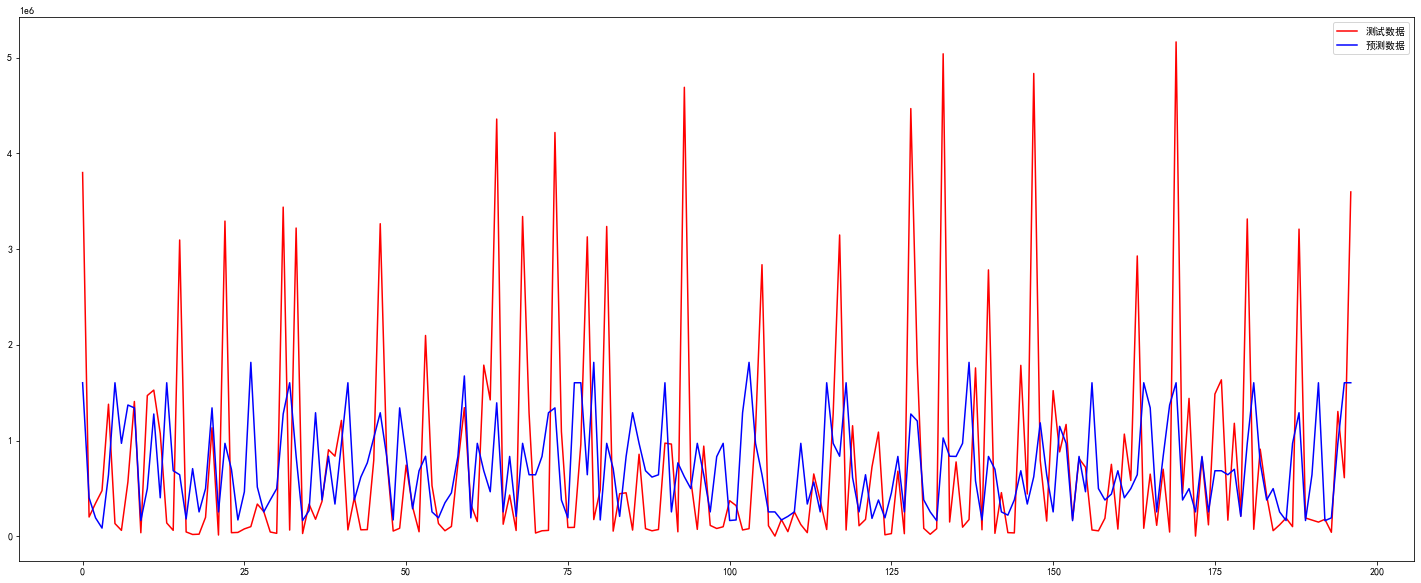

In [20]:
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号
plt.figure(figsize=(25,10))
plt.plot(range(len(y_test)), y_test, 'r', label='测试数据')
plt.plot(range(len(y_pred)), y_pred, 'b', label='预测数据')
plt.legend()
plt.show()